In [ ]:
#HOMEWORK 3 Benedetta Nassi 1000059819
#importo le librerie 

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


In [ ]:
#Carico il dataset 
X_train = np.load('/Users/benedettanassi/Downloads/cifar_hw3/x_train.npy')
y_train = np.load('/Users/benedettanassi/Downloads/cifar_hw3/y_train.npy')
X_test = np.load('/Users/benedettanassi/Downloads/cifar_hw3/x_test.npy')
y_test = np.load('/Users/benedettanassi/Downloads/cifar_hw3/y_test.npy')
X_val= np.load('/Users/benedettanassi/Downloads/cifar_hw3/x_val.npy')
y_val = np.load('/Users/benedettanassi/Downloads/cifar_hw3/y_val.npy')


In [ ]:
# Preprocessing
X_train = X_train.astype('float32').reshape((X_train.shape[0], -1)) / 255.0
X_val = X_val.astype('float32').reshape((X_val.shape[0], -1)) / 255.0
X_test = X_test.astype('float32').reshape((X_test.shape[0], -1)) / 255.0

# Salvo copia originale
X_train_original = X_train.copy()

In [18]:
# Funzione mascheramento 
def maschera_quadrati(X, patch_size=5, diff_threshold=1.5):
    X_masked = X.copy()
    for i in range(X.shape[0]):
        img = X_masked[i].reshape(32, 32, 3)
        img_mean = np.mean(img)
        img_std = np.std(img)
        for y in range(0, 32 - patch_size + 1, patch_size):
            for x in range(0, 32 - patch_size + 1, patch_size):
                patch = img[y:y+patch_size, x:x+patch_size, :]
                patch_mean = np.mean(patch)
                patch_std = np.std(patch)
                if abs(patch_mean - img_mean) > diff_threshold * img_std or patch_std > diff_threshold * img_std:
                    img[y:y+patch_size, x:x+patch_size, :] = 0.5
    return X_masked

#Mascheramento dei dati
X_train_masked = maschera_quadrati(X_train_original)




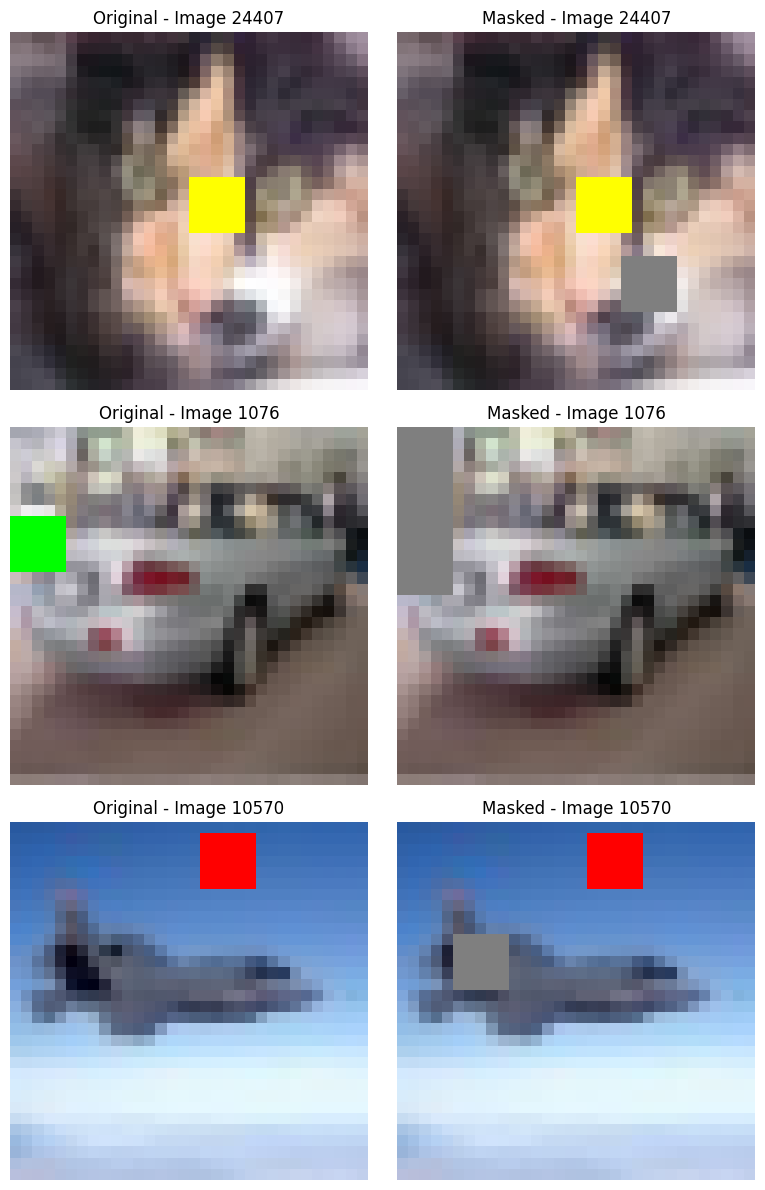

In [ ]:

def compare_mascherate_originali(X_original, num_to_show=3, patch_size=5, diff_threshold=1.5):

    selected_indices = np.random.choice(len(X_original), num_to_show, replace=False)
    
    fig, axs = plt.subplots(num_to_show, 2, figsize=(8, 4 * num_to_show))

    
    if num_to_show == 1:
        axs = np.expand_dims(axs, axis=0)

    for i, idx in enumerate(selected_indices):
        X_single_img = X_original[idx:idx+1].copy() 
        X_masked_single_img = maschera_quadrati(X_single_img, patch_size, diff_threshold)
        
        img_orig = X_original[idx].reshape(32, 32, 3)
        img_masked = X_masked_single_img[0].reshape(32, 32, 3) 

        axs[i, 0].imshow(img_orig)
        axs[i, 0].set_title(f"Original - Image {idx}")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(img_masked)
        axs[i, 1].set_title(f"Masked - Image {idx}")
        axs[i, 1].axis('off')
    
    plt.tight_layout() 
    plt.show()


compare_mascherate_originali(X_train_original)


In [ ]:
# Standardizzazione 
scaler = StandardScaler()
scaler.fit(np.vstack([X_train, X_val]))
X_train_masked = scaler.transform(X_train_masked)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [ ]:
# PCA
pca = PCA(n_components=70)
pca.fit(np.vstack([X_train_masked, X_val]))
X_train_pca = pca.transform(X_train_masked)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)


In [ ]:
# GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(100,10), (100, 50,10), (50, 10)],
    'alpha': [1e-3, 1e-2, 1e-1],
    'learning_rate_init': [1e-3, 1e-2, 1e-1]
}

mlp = MLPClassifier(max_iter=300, early_stopping=True, batch_size=128, random_state=0)
grid = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_pca, y_train)

print(" Migliori parametri trovati:", grid.best_params_)

# Valutazione su validation set
val_pred = grid.predict(X_val_pca)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Validation F1 Macro:", f1_score(y_val, val_pred, average='macro'))


/Users/benedettanassi/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benedettanassi/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benedettanassi/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benedettanassi/Library/Python/3.9/lib/python/site-packages/skle

 Migliori parametri trovati: {'alpha': 0.1, 'hidden_layer_sizes': (100, 50, 10), 'learning_rate_init': 0.01}
Validation Accuracy: 0.4703
Validation F1 Macro: 0.4599982151229033


In [ ]:

import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

/Users/benedettanassi/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_bagging.py:878: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 0.5199
F1 Macro: 0.5145257194999784


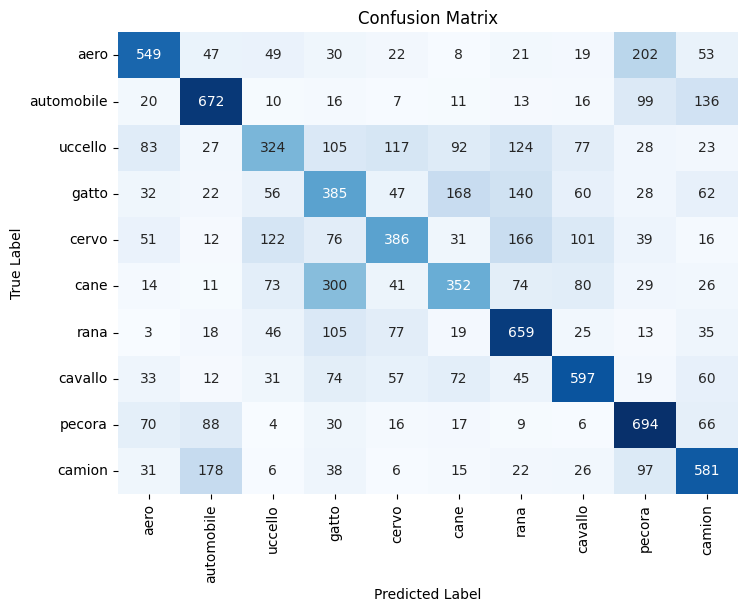

In [29]:
#Bagging su MLP con i migliori parametri trovati
best_params = grid.best_params_
base_mlp = MLPClassifier(**best_params, max_iter=300, early_stopping=True, batch_size=128, random_state=42)

bagging_clf = BaggingClassifier(
    estimator=base_mlp,
    n_estimators=10,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

bagging_clf.fit(X_train_pca, y_train)
y_pred = bagging_clf.predict(X_test_pca)

# Metriche di valutazione
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))


cifar_10_classes = [
    'aero', 'automobile', 'uccello', 'gatto', 'cervo',
    'cane', 'rana', 'cavallo', 'pecora', 'camion'
]


plot_confusion_matrix(y_test, y_pred, classes=cifar_10_classes, title='Confusion Matrix')